In [35]:
import pymongo
import json
import matplotlib.pyplot as plt
import numpy as np

In [36]:
with open('config.json', 'r') as file:
    config = json.load(file)

mongo_uri = config['mongo_uri']
database_name = config['database_name']
softwares_collection = config['container_softwares']

In [37]:
client = pymongo.MongoClient(mongo_uri)
    
# Select the database
db = client[database_name]

# Collection for store software data
softwares_clt = db[softwares_collection]

In [38]:
def get_vulnerable_softwares():
    """
    Get all softwares with vulnerabilities in the database
    Args: None
    Returns: A list of softwares with vulnerabilities    
    """
    vulnerable_softwares = softwares_clt.find({'vulnerabilities': {'$not': {'$size': 0}}}, {'_id': 0})
    return vulnerable_softwares

In [41]:
def impact_vulnerabilities(vulnerable_softwares):
    """
    Create a chart of horizontal bars with the impact of all vulnerabilities (low, medium, high, critical)
    Args: None
    Returns: None
    """
    impact = { 
              'UNKNOWN': 0,
              'LOW': 0,
              'MEDIUM': 0,
              'HIGH': 0,
              'CRITICAL': 0
              }
    for software in vulnerable_softwares:
        for vulnerability in software['vulnerabilities']:
            severity = "UNKNOWN"
            if 'baseSeverity' in vulnerability['metrics']:
                severity = vulnerability['metrics']['baseSeverity']
            if severity in impact:
                impact[severity] += 1
            else:
                impact[severity] += 1

                
    colors = ["#475387","#edc40c","#ed6d0c","#c90e0e","#111111"]
    
    for i, v in enumerate(list(impact.values())):
        plt.text(v + 5 , i, str(v), 
            color = '#1f6b46', fontweight = 'bold')
        
    plt.grid(True, zorder = 1)
    plt.barh(list(impact.keys()), list(impact.values()), color=colors, zorder = 2)
    plt.xlim(0, max(impact.values()) + 20)
    plt.xlabel('Number of vulnerabilities')
    plt.ylabel('Impact')
    plt.title('Impact of vulnerabilities')
    plt.show()
            

In [42]:
def chart_top_ten_vulnerable_softwares():
    """
    Create a chart of vertical bars with the top ten softwares with more vulnerabilities
    The average number of vulnerabilities is represented with a dashed red line
    Args: None
    Returns: None
    """
    softwares_sorted = get_softwares_sorted_by_qty_vulnerabilities()
    average_number_of_vulnerabilities = sum([s['vulnerabilityLength'] for s in softwares_sorted]) / len(softwares_sorted)
    top_ten_softwares = softwares_sorted[:50]
    softwares_names = [s['name'] for s in top_ten_softwares]
    vulnerabilities_count = [s['vulnerabilityLength'] for s in top_ten_softwares]

    plt.bar(softwares_names, vulnerabilities_count)
    plt.axhline(y=average_number_of_vulnerabilities, color='r', linestyle='--')
    plt.xlabel('Software')
    plt.ylabel('Number of Vulnerabilities')
    plt.title('Top Ten Softwares with More Vulnerabilities')
    plt.xticks(rotation=90)
    plt.show()
        

In [43]:
def get_softwares_sorted_by_qty_vulnerabilities():
    """
    Get all softwares sorted by the number of vulnerabilities
    Args: None
    Returns: A list of softwares sorted by the number of vulnerabilities    
    """
    pipeline = [
        {
            "$addFields": {
                "vulnerabilityLength": {"$size": "$vulnerabilities"}  # Replace "yourArrayField" with the actual name of your array field
            }
        },
        {
            "$match": {
                "vulnerabilities": {"$not": {"$size": 0}}
            }
        },
        {
            "$sort": {"vulnerabilityLength": -1}
        },
        {
            "$project": {
                # Exclude the "arrayLength" field if you don't need it in the output
                "_id": 0
            }
        }
    ]
    softwares_sorted = softwares_clt.aggregate(pipeline)
    return list(softwares_sorted)


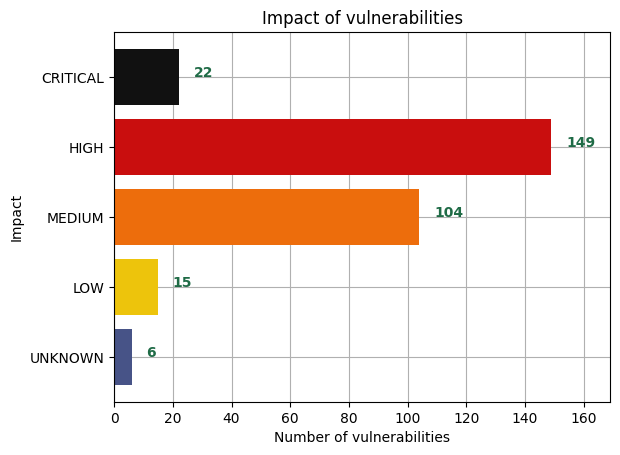

In [48]:
vulnerable_softwares = get_vulnerable_softwares()
impact_vulnerabilities(vulnerable_softwares)